In [29]:
# Automatically reload modules after executing each cell.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import tensorflow as tf
from scipy import stats
import numpy as np
import sklearn.metrics as metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib import rc
import matplotlib.font_manager
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=10)        #22
rc('xtick', labelsize=8)  #15
rc('ytick', labelsize=8)  #15
rc('legend', fontsize=8)  #15
rc('text.latex', preamble=r'\usepackage{amsmath}')

# Plots have dimension (w,h)
w = 3.5
h = 3.25       

from flows import *

import sys
import os

sys.path.append('../')
from utils.training import *
from utils.losses import *

np.random.seed(666)

In [31]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [32]:
mc = np.load("../data/zenodo/Pythia21_Zjet_pTZ-200GeV_0.npz")

sim_pt = mc['sim_jets'][:, 0]
sim_eta = mc['sim_jets'][:, 1]
sim_phi = mc['sim_jets'][:, 2]
sim_m = mc['sim_jets'][:, 3]
sim_mults = mc['sim_mults']
sim_lhas = mc['sim_lhas']
sim_widths = mc['sim_widths']
sim_ang2s = mc['sim_ang2s']
sim_tau2s = mc['sim_tau2s']
sim_sdms = mc['sim_sdms']
sim_zgs = mc['sim_zgs']

sim = np.vstack([sim_pt, sim_eta, sim_phi, sim_m]).T

In [33]:
dat = np.load("../data/zenodo/Herwig_Zjet_pTZ-200GeV_0.npz")

dat_pt =  dat['sim_jets'][:, 0] # dat[:, 0]
dat_eta = dat['sim_jets'][:, 1]
dat_phi = dat['sim_jets'][:, 2]
dat_m =   dat['sim_jets'][:, 3]

dat = np.vstack([dat_pt, dat_eta, dat_phi, dat_m]).T

In [34]:
n, d = dat.shape

# Load Flows

In [35]:
#dat_target = make_target(d)
#dat_target = make_target(d, num_hidden = 16)
#dat_target = make_target(d, num_ffjords = 8)
dat_target = make_target(d) #dat10
sim_target = make_target(d) #sim5

dat_ckpt = tf.train.Checkpoint(dat_target)
sim_ckpt = tf.train.Checkpoint(sim_target)

In [36]:
#dat_ckpt.restore('dat7/ckpt-392')
#dat_ckpt.restore('dat8/ckpt-469')
#dat_ckpt.restore('dat9/ckpt-392')
#dat_ckpt.restore('dat12/ckpt-488')
#sim_ckpt.restore('sim4/ckpt-379')
dat_ckpt.restore('dat/best/ckpt-451')
sim_ckpt.restore('sim/2/ckpt-327')

In [37]:
dat_smp = dat_target.sample(n)
sim_smp = sim_target.sample(n)

# Histograms

In [38]:
def ratio_hist(truth, fit,
               labels,
               color = "gray",
               figsize = (8, 8),
               x_lim = None,
               y_lim = None,
               title = None,
               filename = None):
    fig, axs = plt.subplots(2, 1,
                            figsize = figsize,
                            sharex = True, 
                            gridspec_kw = {'height_ratios': [2, 1]})
    
    truth = truth[(truth > x_lim[0]) & (truth < x_lim[1])]
    fit = fit[(fit > x_lim[0]) & (fit < x_lim[1])]
    
    bins = np.linspace(x_lim[0], x_lim[1], 51)
    
    t_hist = axs[0].hist(truth, bins = bins, density = True, color = color, alpha = 0.25, label = labels[0])
    f_hist = axs[0].hist(fit, bins = bins, density = True, histtype = 'step', color = 'red', label = labels[1])
    
    axs[0].minorticks_on()
    axs[0].tick_params(direction='in', which='both')
    axs[0].legend()
    
    if y_lim:
        axs[0].set_ylim(y_lim[0], y_lim[1])
    if x_lim:
        axs[0].set_xlim(x_lim[0], x_lim[1])
    
    bins = (f_hist[1] + np.diff(f_hist[1]).mean() / 2)[:-1]
    axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)
    axs[1].axhline(1,color="gray", lw=0.5)
    
    axs[1].minorticks_on()
    axs[1].tick_params(direction='in', which='both')
    axs[1].set_ylim(0, 2)
    
    plt.xlabel(labels[2])
    
    if title:
        axs[0].set_title(title, loc = "right")
    if filename:
        plt.savefig(filename, 
                    dpi = 300,
                    transparent = True,
                    bbox_inches = 'tight')

## Data

In [39]:
with tf.GradientTape() as tape:
    loss = -tf.reduce_mean(dat_target.log_prob(dat[0:1000, :]))
    
loss = round(loss.numpy(), 2)
loss

12.48

In [40]:
experiment = 'dat/best'

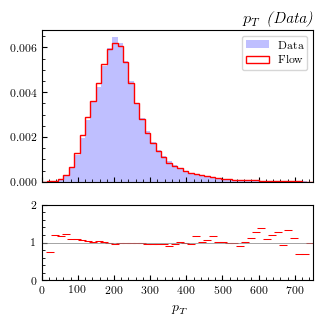

In [41]:
ratio_hist(dat[:, 0], dat_smp[:, 0], 
           labels = ['Data', 'Flow', r'$p_T$'],
           color = 'blue',
           figsize = (w, h),
           title = r'\it $p_T$ (Data)',
           x_lim = (0, 750),
           filename = '../plots/zenodo/flows/{}/pT_data.png'.format(experiment)
          )

/tmp/ipykernel_30848/384005121.py:32: RuntimeWarning: divide by zero encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)
/tmp/ipykernel_30848/384005121.py:32: RuntimeWarning: invalid value encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)


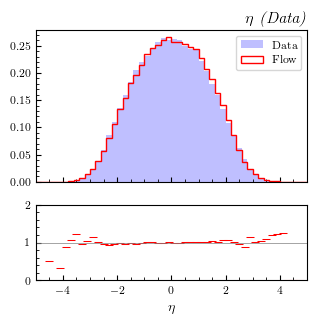

In [42]:
ratio_hist(dat[:, 1], dat_smp[:, 1], 
           labels = ['Data', 'Flow', r'$\eta$'],
           color = 'blue',
           figsize = (w, h),
           title = r'\it $\eta$ (Data)',
           x_lim = (-5, 5),
           filename = '../plots/zenodo/flows/{}/eta_data.png'.format(experiment)
          )

/tmp/ipykernel_30848/384005121.py:32: RuntimeWarning: divide by zero encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)
/tmp/ipykernel_30848/384005121.py:32: RuntimeWarning: invalid value encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)


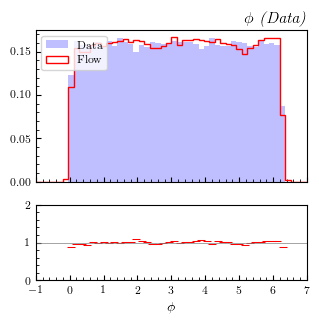

In [43]:
ratio_hist(dat[:, 2], dat_smp[:, 2], 
           labels = ['Data', 'Flow', r'$\phi$'],
           color = 'blue',
           figsize = (w, h),
           title = r'\it $\phi$ (Data)',
           x_lim = (-1, 7),
           filename = '../plots/zenodo/flows/{}/phi_data.png'.format(experiment)
          )

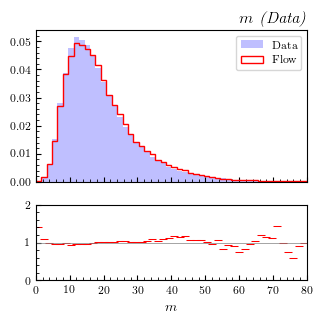

In [44]:
ratio_hist(dat[:, 3], dat_smp[:, 3], 
           labels = ['Data', 'Flow', r'$m$'],
           color = 'blue',
           figsize = (w, h),
           title = r'\it $m$ (Data)',
           x_lim = (0, 80),
           filename = '../plots/zenodo/flows/{}/m_data.png'.format(experiment)
          )

## MC

In [45]:
with tf.GradientTape() as tape:
    loss = -tf.reduce_mean(sim_target.log_prob(sim[0:1000, :]))
    
loss = round(loss.numpy(), 2)
loss

12.61

In [46]:
experiment = 'sim/2'

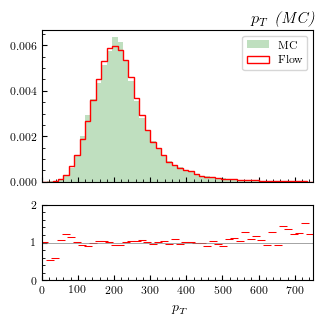

In [47]:
ratio_hist(sim[:, 0], sim_smp[:, 0], 
           labels = ['MC', 'Flow', r'$p_T$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $p_T$ (MC)',
           x_lim = (0, 750),
           filename = '../plots/zenodo/flows/{}/pT_mc.png'.format(experiment)
          )

/tmp/ipykernel_30848/384005121.py:32: RuntimeWarning: divide by zero encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)
/tmp/ipykernel_30848/384005121.py:32: RuntimeWarning: invalid value encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)


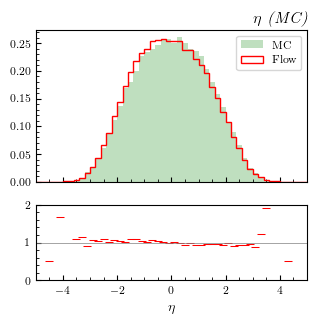

In [48]:
ratio_hist(sim[:, 1], sim_smp[:, 1], 
           labels = ['MC', 'Flow', r'$\eta$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $\eta$ (MC)',
           x_lim = (-5, 5),
           filename = '../plots/zenodo/flows/{}/eta_mc.png'.format(experiment)
          )

/tmp/ipykernel_30848/384005121.py:32: RuntimeWarning: divide by zero encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)
/tmp/ipykernel_30848/384005121.py:32: RuntimeWarning: invalid value encountered in divide
  axs[1].scatter(bins, f_hist[0] / t_hist[0], marker = '_', c = 'red', lw = 0.75)


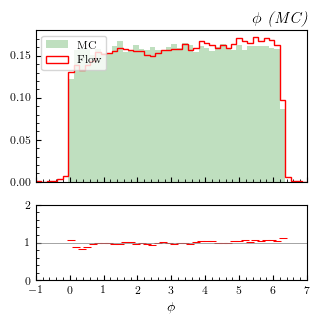

In [49]:
ratio_hist(sim[:, 2], sim_smp[:, 2], 
           labels = ['MC', 'Flow', r'$\phi$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $\phi$ (MC)',
           x_lim = (-1, 7),
           filename = '../plots/zenodo/flows/{}/phi_mc.png'.format(experiment)
          )

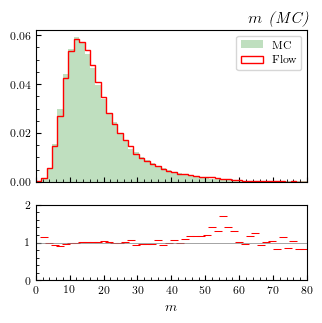

In [50]:
ratio_hist(sim[:, 3], sim_smp[:, 3], 
           labels = ['MC', 'Flow', r'$m$'],
           color = 'green',
           figsize = (w, h),
           title = r'\it $m$ (MC)',
           x_lim = (0, 80),
           filename = '../plots/zenodo/flows/{}/m_mc.png'.format(experiment)
          )

# Classification

## MC

In [ ]:
X_bkgd = sim_smp
X_sgnl = sim

In [ ]:
np.random.seed(666)

# Create full dataset; randomly sample points from Data or Flow with chance 1/2.
y = stats.bernoulli.rvs(0.5, size = n).astype('float32')
X = np.zeros_like(X_bkgd)

X[y == 0] = X_bkgd[y == 0]
X[y == 1] = X_sgnl[y == 1]

# Take 70% of data to be training data.
N_trn = int(0.7*n)
trn_idx = np.random.choice(range(n), N_trn, replace = False)
tst_idx = [n for n in range(n) if n not in trn_idx]

X_trn = X[trn_idx]
y_trn = y[trn_idx]

X_tst = X[tst_idx]
y_tst = y[tst_idx]

data, m, s = split_data(X_trn, y_trn)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ab_clf = AdaBoostClassifier()
ab_clf.fit(X_trn, y_trn)

In [ ]:
y_hat = ab_clf.predict_proba(X_tst)[:, 1]
fpr, tpr, ts = metrics.roc_curve(y_tst, y_hat)
auc = metrics.roc_auc_score(y_tst, y_hat)

In [ ]:
fig, ax = plt.subplots(figsize = (w, h))
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, ls = ':', c = 'k', lw = 1)

plt.title('\it ROC Curve for MC', loc = 'right')
plt.text(0.05, 0.9, 'AUC: {}'.format(round(auc, 4)))
plt.text(0.04, 0.85, 'Loss: {}'.format(loss))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim(0, 1)
plt.xlim(0, 1)

plt.gca().minorticks_on()
plt.gca().tick_params(direction='in', which='both')
plt.gca().set_aspect('equal')

plt.savefig('../plots/zenodo/flows/{}/mc_roc.png'.format(experiment), dpi = 300, transparent = True,
            bbox_inches = 'tight')

## Data

In [ ]:
X_bkgd = dat_smp
X_sgnl = dat

In [ ]:
np.random.seed(666)

# Create full dataset; randomly sample points from Data or Flow with chance 1/2.
y = stats.bernoulli.rvs(0.5, size = n).astype('float32')
X = np.zeros_like(X_bkgd)

X[y == 0] = X_bkgd[y == 0]
X[y == 1] = X_sgnl[y == 1]

# Take 70% of data to be training data.
N_trn = int(0.7*n)
trn_idx = np.random.choice(range(n), N_trn, replace = False)
tst_idx = [n for n in range(n) if n not in trn_idx]

X_trn = X[trn_idx]
y_trn = y[trn_idx]

X_tst = X[tst_idx]
y_tst = y[tst_idx]

data, m, s = split_data(X_trn, y_trn)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ab_clf = AdaBoostClassifier()
ab_clf.fit(X_trn, y_trn)

In [ ]:
y_hat = ab_clf.predict_proba(X_tst)[:, 1]
fpr, tpr, ts = metrics.roc_curve(y_tst, y_hat)
auc = metrics.roc_auc_score(y_tst, y_hat)

In [ ]:
fig, ax = plt.subplots(figsize = (w, h))
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, ls = ':', c = 'k', lw = 1)

plt.title('\it ROC Curve for Data', loc = 'right')
plt.text(0.05, 0.9, 'AUC: {}'.format(round(auc, 4)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim(0, 1)
plt.xlim(0, 1)

plt.gca().minorticks_on()
plt.gca().tick_params(direction='in', which='both')
plt.gca().set_aspect('equal')

plt.savefig('../plots/zenodo/flows/{}/data_roc.png'.format(experiment), dpi = 300, transparent = True,
            bbox_inches = 'tight')

# Checkpoint Checks

In [ ]:
def calculate_auc(fake, real):
    np.random.seed(666)
    n, d = fake.shape
    y = stats.bernoulli.rvs(0.5, size = n).astype('float32')
    X = np.zeros_like(fake)
    X[y == 0] = real[y == 0]
    X[y == 1] = fake[y == 1]

    # Take 70% of data to be training data.
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, train_size = 0.7)
    ab_clf = AdaBoostClassifier()
    ab_clf.fit(X_trn, y_trn)
    
    y_hat = ab_clf.predict_proba(X_tst)[:, 1]
    auc = metrics.roc_auc_score(y_tst, y_hat)
    return auc

## Dat Best

In [25]:
num_ckpts = 534
ns = np.arange(1, num_ckpts + 1)

aucs = np.zeros(num_ckpts)

for i in ns:
    dat_target = make_target(d)
    dat_ckpt = tf.train.Checkpoint(dat_target)
    dat_ckpt.restore('dat/best/ckpt-{}'.format(i))
    
    dat_smp = dat_target.sample(n)
    aucs[i - 1] = calculate_auc(dat_smp, dat)
    print(i, '\t', round(aucs[i - 1], 4))

1 	 1.0
2 	 1.0
3 	 0.9983
4 	 0.9862
5 	 0.9716
6 	 0.9652
7 	 0.9024
8 	 0.8397
9 	 0.7777
10 	 0.7273
11 	 0.6906
12 	 0.6579
13 	 0.6378
14 	 0.6188
15 	 0.6147
16 	 0.6125
17 	 0.6072
18 	 0.603
19 	 0.5992
20 	 0.5963
21 	 0.5916
22 	 0.5941
23 	 0.5863
24 	 0.5878
25 	 0.5887
26 	 0.5882
27 	 0.5906
28 	 0.5885
29 	 0.574
30 	 0.5858
31 	 0.5762
32 	 0.5714
33 	 0.5749
34 	 0.5708
35 	 0.572
36 	 0.575
37 	 0.5752
38 	 0.5749
39 	 0.5766
40 	 0.5674
41 	 0.5944
42 	 0.5652
43 	 0.5653
44 	 0.5698
45 	 0.5706
46 	 0.5592
47 	 0.5577
48 	 0.5734
49 	 0.5456
50 	 0.564
51 	 0.5565
52 	 0.551
53 	 0.5534
54 	 0.5735
55 	 0.5765
56 	 0.5558
57 	 0.5533
58 	 0.5729
59 	 0.5779
60 	 0.5558
61 	 0.5649
62 	 0.5864
63 	 0.5578
64 	 0.5759
65 	 0.5563
66 	 0.5705
67 	 0.5465
68 	 0.556
69 	 0.5652
70 	 0.5537
71 	 0.56
72 	 0.5689
73 	 0.573
74 	 0.5566
75 	 0.5612
76 	 0.5462
77 	 0.552
78 	 0.5529
79 	 0.548
80 	 0.5441
81 	 0.5492
82 	 0.5437
83 	 0.5507
84 	 0.5531
85 	 0.5551
86 	 0.

[451] 	 [0.51566031]


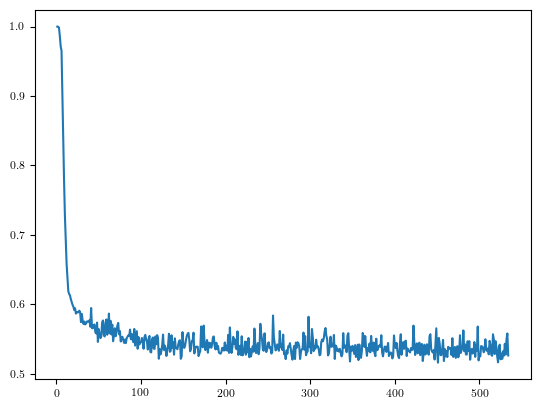

In [26]:
plt.plot(ns, aucs)
print(ns[aucs == np.min(aucs)], '\t', aucs[aucs == np.min(aucs)])

(0.51, 0.57)

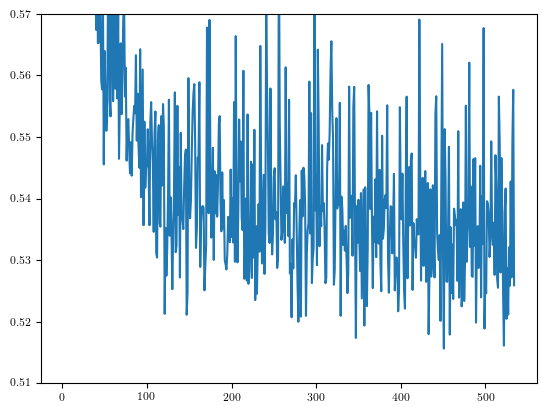

In [28]:
plt.plot(ns, aucs)
plt.ylim(0.51, 0.57)

# Sim 1

In [7]:
num_ckpts = 77
num_sim = 1
ns = np.arange(1, num_ckpts + 1)

aucs = np.zeros(num_ckpts)

for i in ns:
    sim_target = make_target(d)
    sim_ckpt = tf.train.Checkpoint(sim_target)
    sim_ckpt.restore('sim/{}/ckpt-{}'.format(num_sim, i))
    
    sim_smp = sim_target.sample(n)
    aucs[i - 1] = calculate_auc(sim_smp, sim)
    print(i, '\t', round(aucs[i - 1], 4))

2023-10-20 21:10:12.661441: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-20 21:10:13.343034: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21791 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:81:00.0, compute capability: 7.5


1 	 0.8616
2 	 0.6797
3 	 0.6231
4 	 0.6156
5 	 0.6258
6 	 0.6367
7 	 0.6186
8 	 0.5949
9 	 0.6403
10 	 0.6028
11 	 0.5895
12 	 0.5898
13 	 0.6369
14 	 0.6124
15 	 0.6321
16 	 0.6108
17 	 0.5983
18 	 0.6033
19 	 0.5867
20 	 0.6129
21 	 0.623
22 	 0.6288
23 	 0.5734
24 	 0.5893
25 	 0.5931
26 	 0.5869
27 	 0.5777
28 	 0.5987
29 	 0.6352
30 	 0.598
31 	 0.5848
32 	 0.5982
33 	 0.576
34 	 0.5894
35 	 0.5851
36 	 0.6143
37 	 0.656
38 	 0.6071
39 	 0.6277
40 	 0.6464
41 	 0.5914
42 	 0.6159
43 	 0.6983
44 	 0.6646
45 	 0.6835
46 	 0.7079
47 	 0.6605
48 	 0.6967
49 	 0.6507
50 	 0.6561
51 	 0.6776
52 	 0.6752
53 	 0.6667
54 	 0.6684
55 	 0.7022
56 	 0.6812
57 	 0.7813
58 	 0.7369
59 	 0.6817
60 	 0.7103
61 	 0.6729
62 	 0.8035
63 	 0.6773
64 	 0.6738
65 	 0.7146
66 	 0.6658
67 	 0.659
68 	 0.7412
69 	 0.7182
70 	 0.6731
71 	 0.7213
72 	 0.6388
73 	 0.6541
74 	 0.6223
75 	 0.6506
76 	 0.6307
77 	 0.6245


[23] 	 [0.57342746]


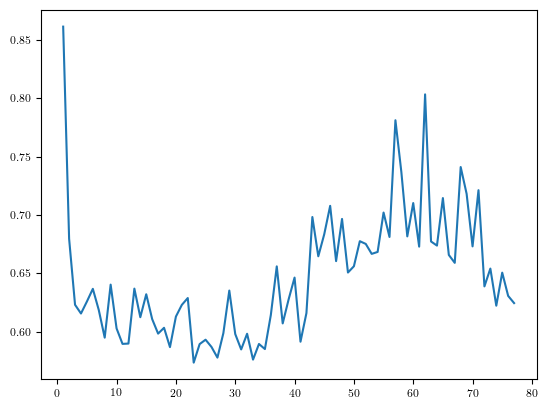

In [8]:
plt.plot(ns, aucs)
print(ns[aucs == np.min(aucs)], '\t', aucs[aucs == np.min(aucs)])

## Sim 2

In [9]:
num_ckpts = 392
num_sim = 2
ns = np.arange(1, num_ckpts + 1)

aucs = np.zeros(num_ckpts)

for i in ns:
    sim_target = make_target(d)
    sim_ckpt = tf.train.Checkpoint(sim_target)
    sim_ckpt.restore('sim/{}/ckpt-{}'.format(num_sim, i))
    
    sim_smp = sim_target.sample(n)
    aucs[i - 1] = calculate_auc(sim_smp, sim)
    print(i, '\t', round(aucs[i - 1], 4))

1 	 1.0
2 	 1.0
3 	 0.9965
4 	 0.9822
5 	 0.9594
6 	 0.9315
7 	 0.8939
8 	 0.8427
9 	 0.7883
10 	 0.7431
11 	 0.6929
12 	 0.6619
13 	 0.6345
14 	 0.6142
15 	 0.6129
16 	 0.5964
17 	 0.5996
18 	 0.5825
19 	 0.5814
20 	 0.5712
21 	 0.601
22 	 0.5729
23 	 0.5719
24 	 0.5721
25 	 0.5664
26 	 0.5621
27 	 0.5571
28 	 0.5714
29 	 0.5603
30 	 0.6024
31 	 0.561
32 	 0.5582
33 	 0.5652
34 	 0.5737
35 	 0.551
36 	 0.5617
37 	 0.5539
38 	 0.5485
39 	 0.5555
40 	 0.5437
41 	 0.5474
42 	 0.5459
43 	 0.5545
44 	 0.5622
45 	 0.5581
46 	 0.5669
47 	 0.5563
48 	 0.5375
49 	 0.5704
50 	 0.5556
51 	 0.5831
52 	 0.551
53 	 0.5528
54 	 0.5602
55 	 0.5441
56 	 0.5409
57 	 0.5656
58 	 0.5378
59 	 0.5616
60 	 0.5565
61 	 0.5545
62 	 0.5448
63 	 0.5577
64 	 0.5522
65 	 0.5556
66 	 0.5567
67 	 0.5364
68 	 0.5616
69 	 0.5439
70 	 0.5556
71 	 0.5669
72 	 0.5571
73 	 0.5577
74 	 0.5435
75 	 0.5599
76 	 0.5676
77 	 0.555
78 	 0.5537
79 	 0.5529
80 	 0.545
81 	 0.5634
82 	 0.5338
83 	 0.5391
84 	 0.5621
85 	 0.5491
8

[327] 	 [0.52060069]


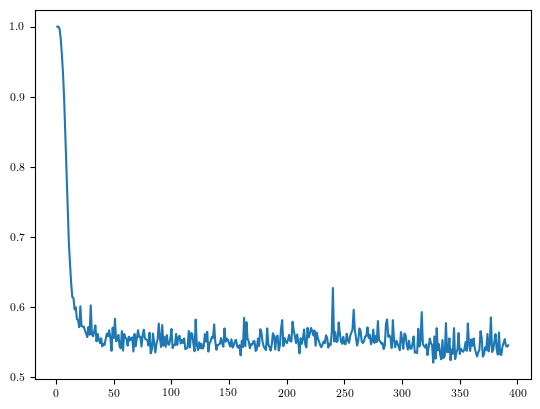

In [10]:
plt.plot(ns, aucs)
print(ns[aucs == np.min(aucs)], '\t', aucs[aucs == np.min(aucs)])

## Sim 3

In [11]:
num_ckpts = 392
num_sim = 3
ns = np.arange(1, num_ckpts + 1)

aucs = np.zeros(num_ckpts)

for i in ns:
    sim_target = make_target(d)
    sim_ckpt = tf.train.Checkpoint(sim_target)
    sim_ckpt.restore('sim/{}/ckpt-{}'.format(num_sim, i))
    
    sim_smp = sim_target.sample(n)
    aucs[i - 1] = calculate_auc(sim_smp, sim)
    print(i, '\t', round(aucs[i - 1], 4))

1 	 1.0
2 	 1.0
3 	 1.0
4 	 1.0
5 	 1.0
6 	 1.0
7 	 1.0
8 	 1.0
9 	 1.0
10 	 1.0
11 	 1.0
12 	 1.0
13 	 1.0
14 	 1.0
15 	 1.0
16 	 1.0
17 	 1.0
18 	 1.0
19 	 1.0
20 	 0.9999
21 	 0.9999
22 	 0.9998
23 	 0.9997
24 	 0.9994
25 	 0.999
26 	 0.9985
27 	 0.9975
28 	 0.9965
29 	 0.9953
30 	 0.9939
31 	 0.9925
32 	 0.9905
33 	 0.9889
34 	 0.9869
35 	 0.9841
36 	 0.9822
37 	 0.9795
38 	 0.9771
39 	 0.9742
40 	 0.9706
41 	 0.9685
42 	 0.9643
43 	 0.9609
44 	 0.9576
45 	 0.9541
46 	 0.9515
47 	 0.948
48 	 0.9416
49 	 0.9391
50 	 0.933
51 	 0.9277
52 	 0.9219
53 	 0.9152
54 	 0.9083
55 	 0.898
56 	 0.892
57 	 0.8828
58 	 0.8765
59 	 0.8662
60 	 0.8573
61 	 0.8478
62 	 0.839
63 	 0.8296
64 	 0.8226
65 	 0.8143
66 	 0.8073
67 	 0.8016
68 	 0.7891
69 	 0.7833
70 	 0.7724
71 	 0.7668
72 	 0.7582
73 	 0.7514
74 	 0.7475
75 	 0.7423
76 	 0.731
77 	 0.7232
78 	 0.7208
79 	 0.7114
80 	 0.7077
81 	 0.7003
82 	 0.6973
83 	 0.6898
84 	 0.6837
85 	 0.6877
86 	 0.6808
87 	 0.68
88 	 0.6721
89 	 0.6703
90 	 0.

[368] 	 [0.53725623]


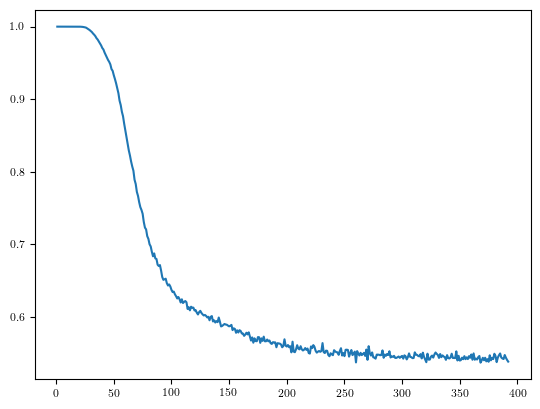

In [12]:
plt.plot(ns, aucs)
print(ns[aucs == np.min(aucs)], '\t', aucs[aucs == np.min(aucs)])

## Sim 4

In [13]:
num_ckpts = 39
num_sim = 4
ns = np.arange(1, num_ckpts + 1)

aucs = np.zeros(num_ckpts)

for i in ns:
    sim_target = make_target(d)
    sim_ckpt = tf.train.Checkpoint(sim_target)
    sim_ckpt.restore('sim/{}/ckpt-{}'.format(num_sim, i))
    
    sim_smp = sim_target.sample(n)
    aucs[i - 1] = calculate_auc(sim_smp, sim)
    print(i, '\t', round(aucs[i - 1], 4))

1 	 0.8663
2 	 0.6853
3 	 0.6484
4 	 0.6095
5 	 0.6064
6 	 0.7019
7 	 0.6432
8 	 0.6044
9 	 0.6093
10 	 0.6265
11 	 0.5761
12 	 0.576
13 	 0.6161
14 	 0.6216
15 	 0.5911
16 	 0.6036
17 	 0.5795
18 	 0.6528
19 	 0.5836
20 	 0.5987
21 	 0.6275
22 	 0.587
23 	 0.6594
24 	 0.6671
25 	 0.6579
26 	 0.6149
27 	 0.765
28 	 0.6995
29 	 0.6348
30 	 0.696
31 	 0.6175
32 	 0.6349
33 	 0.9304
34 	 0.7302
35 	 0.6216
36 	 0.6634
37 	 0.6714
38 	 0.659
39 	 0.6604


[12] 	 [0.57602636]


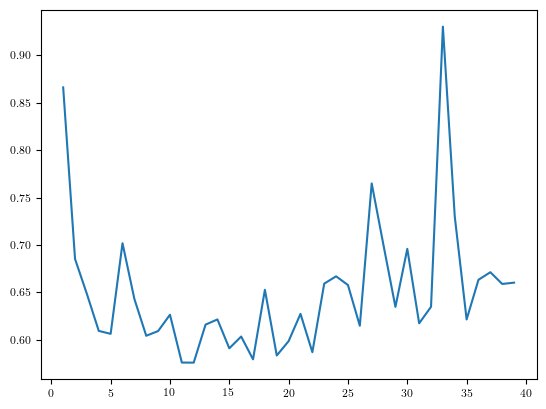

In [14]:
plt.plot(ns, aucs)
print(ns[aucs == np.min(aucs)], '\t', aucs[aucs == np.min(aucs)])

## Sim 5

In [15]:
num_ckpts = 196
num_sim = 5
ns = np.arange(1, num_ckpts + 1)

aucs = np.zeros(num_ckpts)

for i in ns:
    sim_target = make_target(d)
    sim_ckpt = tf.train.Checkpoint(sim_target)
    sim_ckpt.restore('sim/{}/ckpt-{}'.format(num_sim, i))
    
    sim_smp = sim_target.sample(n)
    aucs[i - 1] = calculate_auc(sim_smp, sim)
    print(i, '\t', round(aucs[i - 1], 4))

1 	 1.0
2 	 1.0
3 	 0.999
4 	 0.993
5 	 0.9797
6 	 0.9375
7 	 0.8742
8 	 0.8129
9 	 0.7609
10 	 0.7338
11 	 0.7031
12 	 0.6539
13 	 0.6243
14 	 0.6076
15 	 0.5993
16 	 0.586
17 	 0.5818
18 	 0.5765
19 	 0.6157
20 	 0.5752
21 	 0.5745
22 	 0.5764
23 	 0.5681
24 	 0.5564
25 	 0.5464
26 	 0.5678
27 	 0.5707
28 	 0.5545
29 	 0.5481
30 	 0.5649
31 	 0.5531
32 	 0.5448
33 	 0.5538
34 	 0.5654
35 	 0.5485
36 	 0.563
37 	 0.5439
38 	 0.5493
39 	 0.5575
40 	 0.5466
41 	 0.5547
42 	 0.5476
43 	 0.5626
44 	 0.5443
45 	 0.5395
46 	 0.5498
47 	 0.5382
48 	 0.5407
49 	 0.5394
50 	 0.5563
51 	 0.5416
52 	 0.5589
53 	 0.5547
54 	 0.535
55 	 0.536
56 	 0.5464
57 	 0.5559
58 	 0.5705
59 	 0.5398
60 	 0.5426
61 	 0.5487
62 	 0.5773
63 	 0.5432
64 	 0.5585
65 	 0.5392
66 	 0.5546
67 	 0.5491
68 	 0.5288
69 	 0.5515
70 	 0.5443
71 	 0.548
72 	 0.5509
73 	 0.5518
74 	 0.5561
75 	 0.5495
76 	 0.558
77 	 0.5455
78 	 0.5433
79 	 0.5392
80 	 0.5452
81 	 0.5493
82 	 0.5729
83 	 0.5326
84 	 0.544
85 	 0.5615
86 	

[135] 	 [0.52152262]


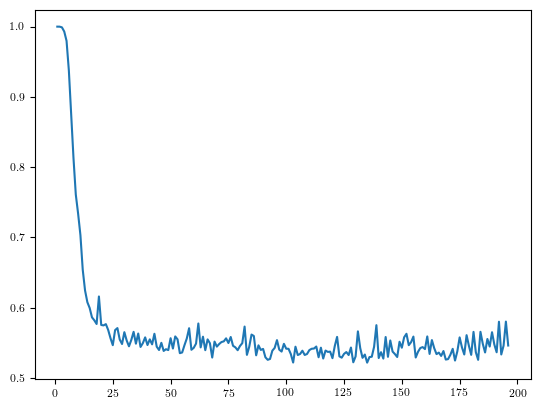

In [16]:
plt.plot(ns, aucs)
print(ns[aucs == np.min(aucs)], '\t', aucs[aucs == np.min(aucs)])

## Sim 6

In [17]:
num_ckpts = 196
num_sim = 6
ns = np.arange(1, num_ckpts + 1)

aucs = np.zeros(num_ckpts)

for i in ns:
    sim_target = make_target(d)
    sim_ckpt = tf.train.Checkpoint(sim_target)
    sim_ckpt.restore('sim/{}/ckpt-{}'.format(num_sim, i))
    
    sim_smp = sim_target.sample(n)
    aucs[i - 1] = calculate_auc(sim_smp, sim)
    print(i, '\t', round(aucs[i - 1], 4))

1 	 1.0
2 	 1.0
3 	 1.0
4 	 1.0
5 	 0.9999
6 	 0.9999
7 	 1.0
8 	 1.0
9 	 1.0
10 	 1.0
11 	 1.0
12 	 1.0
13 	 1.0
14 	 1.0
15 	 1.0
16 	 1.0
17 	 1.0
18 	 1.0
19 	 0.9999
20 	 0.9999
21 	 0.9998
22 	 0.9995
23 	 0.9992
24 	 0.9986
25 	 0.998
26 	 0.9972
27 	 0.9961
28 	 0.9947
29 	 0.9935
30 	 0.9915
31 	 0.9895
32 	 0.9874
33 	 0.9848
34 	 0.9827
35 	 0.9799
36 	 0.9776
37 	 0.9762
38 	 0.9739
39 	 0.9714
40 	 0.9691
41 	 0.9651
42 	 0.9602
43 	 0.9561
44 	 0.9513
45 	 0.9459
46 	 0.9405
47 	 0.9353
48 	 0.9304
49 	 0.923
50 	 0.9171
51 	 0.9094
52 	 0.9052
53 	 0.8984
54 	 0.8898
55 	 0.8821
56 	 0.875
57 	 0.8655
58 	 0.8589
59 	 0.8502
60 	 0.8427
61 	 0.8341
62 	 0.8254
63 	 0.8163
64 	 0.8096
65 	 0.7993
66 	 0.7904
67 	 0.7829
68 	 0.7775
69 	 0.7683
70 	 0.7594
71 	 0.7525
72 	 0.748
73 	 0.7404
74 	 0.7366
75 	 0.7252
76 	 0.7177
77 	 0.715
78 	 0.7093
79 	 0.7048
80 	 0.6991
81 	 0.6943
82 	 0.6849
83 	 0.686
84 	 0.6817
85 	 0.6728
86 	 0.6686
87 	 0.6663
88 	 0.6618
89 	 0.

[196] 	 [0.5681135]


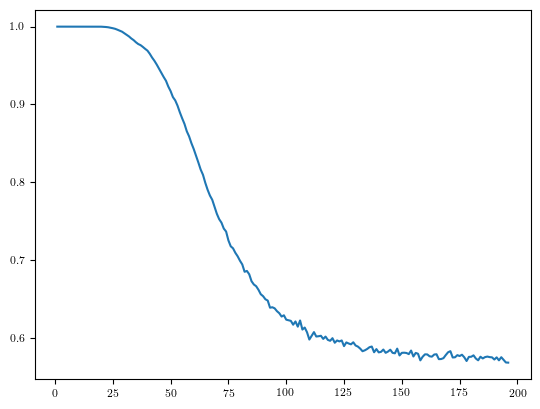

In [18]:
plt.plot(ns, aucs)
print(ns[aucs == np.min(aucs)], '\t', aucs[aucs == np.min(aucs)])

## Sim 7

In [19]:
num_ckpts = 47
num_sim = 7
ns = np.arange(1, num_ckpts + 1)

aucs = np.zeros(num_ckpts)

for i in ns:
    sim_target = make_target(d)
    sim_ckpt = tf.train.Checkpoint(sim_target)
    sim_ckpt.restore('sim/{}/ckpt-{}'.format(num_sim, i))
    
    sim_smp = sim_target.sample(n)
    aucs[i - 1] = calculate_auc(sim_smp, sim)
    print(i, '\t', round(aucs[i - 1], 4))

1 	 0.8642
2 	 0.7273
3 	 0.6659
4 	 0.5979
5 	 0.6029
6 	 0.5955
7 	 0.558
8 	 0.5573
9 	 0.5743
10 	 0.5528
11 	 0.578
12 	 0.5651
13 	 0.5406
14 	 0.6122
15 	 0.561
16 	 0.5908
17 	 0.591
18 	 0.6378
19 	 0.611
20 	 0.6438
21 	 0.5906
22 	 0.5833
23 	 0.6218
24 	 0.5809
25 	 0.5935
26 	 0.5972
27 	 0.5805
28 	 0.5885
29 	 0.5907
30 	 0.592
31 	 0.5762
32 	 0.5812
33 	 0.5762
34 	 0.5612
35 	 0.5825
36 	 0.6935
37 	 0.6615
38 	 0.7861
39 	 0.7299
40 	 0.9598
41 	 0.8202
42 	 0.8887
43 	 0.7615
44 	 0.7359
45 	 0.744
46 	 0.7177
47 	 0.716


[13] 	 [0.54064238]


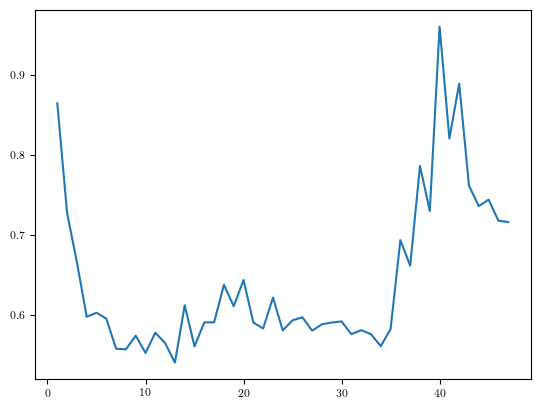

In [20]:
plt.plot(ns, aucs)
print(ns[aucs == np.min(aucs)], '\t', aucs[aucs == np.min(aucs)])

## Sim 8

In [21]:
num_ckpts = 99
num_sim = 8
ns = np.arange(1, num_ckpts + 1)

aucs = np.zeros(num_ckpts)

for i in ns:
    sim_target = make_target(d)
    sim_ckpt = tf.train.Checkpoint(sim_target)
    sim_ckpt.restore('sim/{}/ckpt-{}'.format(num_sim, i))
    
    sim_smp = sim_target.sample(n)
    aucs[i - 1] = calculate_auc(sim_smp, sim)
    print(i, '\t', round(aucs[i - 1], 4))

1 	 1.0
2 	 0.9998
3 	 0.9962
4 	 0.9807
5 	 0.956
6 	 0.9219
7 	 0.8735
8 	 0.8137
9 	 0.7649
10 	 0.7271
11 	 0.6921
12 	 0.6636
13 	 0.6328
14 	 0.6163
15 	 0.5974
16 	 0.6015
17 	 0.5953
18 	 0.5904
19 	 0.5896
20 	 0.5754
21 	 0.5698
22 	 0.5672
23 	 0.5612
24 	 0.5619
25 	 0.5751
26 	 0.5593
27 	 0.5555
28 	 0.5603
29 	 0.5589
30 	 0.554
31 	 0.5392
32 	 0.5497
33 	 0.5428
34 	 0.5487
35 	 0.5457
36 	 0.5459
37 	 0.5552
38 	 0.5391
39 	 0.5513
40 	 0.5533
41 	 0.5371
42 	 0.546
43 	 0.5472
44 	 0.5485
45 	 0.5435
46 	 0.5549
47 	 0.5406
48 	 0.5365
49 	 0.5464
50 	 0.5342
51 	 0.5447
52 	 0.5492
53 	 0.5326
54 	 0.5407
55 	 0.5357
56 	 0.5331
57 	 0.5441
58 	 0.5373
59 	 0.5416
60 	 0.5491
61 	 0.5456
62 	 0.6028
63 	 0.5401
64 	 0.5334
65 	 0.5388
66 	 0.5344
67 	 0.539
68 	 0.5385
69 	 0.5263
70 	 0.5459
71 	 0.5357
72 	 0.5375
73 	 0.5427
74 	 0.5247
75 	 0.5494
76 	 0.5373
77 	 0.5348
78 	 0.5285
79 	 0.5349
80 	 0.5492
81 	 0.5406
82 	 0.5344
83 	 0.5459
84 	 0.5497
85 	 0.5

[74] 	 [0.52472416]


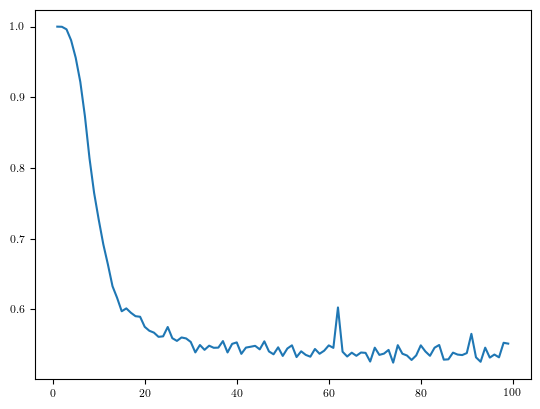

In [22]:
plt.plot(ns, aucs)
print(ns[aucs == np.min(aucs)], '\t', aucs[aucs == np.min(aucs)])

## Sim 9

In [23]:
num_ckpts = 99
num_sim = 9
ns = np.arange(1, num_ckpts + 1)

aucs = np.zeros(num_ckpts)

for i in ns:
    sim_target = make_target(d)
    sim_ckpt = tf.train.Checkpoint(sim_target)
    sim_ckpt.restore('sim/{}/ckpt-{}'.format(num_sim, i))
    
    sim_smp = sim_target.sample(n)
    aucs[i - 1] = calculate_auc(sim_smp, sim)
    print(i, '\t', round(aucs[i - 1], 4))

1 	 1.0
2 	 1.0
3 	 1.0
4 	 1.0
5 	 1.0
6 	 1.0
7 	 1.0
8 	 1.0
9 	 1.0
10 	 1.0
11 	 1.0
12 	 1.0
13 	 1.0
14 	 1.0
15 	 1.0
16 	 1.0
17 	 1.0
18 	 1.0
19 	 1.0
20 	 0.9999
21 	 0.9999
22 	 0.9997
23 	 0.9996
24 	 0.9994
25 	 0.999
26 	 0.9982
27 	 0.9973
28 	 0.996
29 	 0.9946
30 	 0.9927
31 	 0.9907
32 	 0.9884
33 	 0.9866
34 	 0.9843
35 	 0.9813
36 	 0.9784
37 	 0.9751
38 	 0.9709
39 	 0.9677
40 	 0.9646
41 	 0.9604
42 	 0.9559
43 	 0.9511
44 	 0.9468
45 	 0.9419
46 	 0.938
47 	 0.9322
48 	 0.9264
49 	 0.9191
50 	 0.9121
51 	 0.9064
52 	 0.8983
53 	 0.8896
54 	 0.8811
55 	 0.8753
56 	 0.867
57 	 0.8598
58 	 0.8513
59 	 0.8445
60 	 0.8384
61 	 0.8257
62 	 0.8203
63 	 0.8115
64 	 0.8027
65 	 0.7966
66 	 0.7872
67 	 0.7832
68 	 0.7726
69 	 0.7638
70 	 0.7627
71 	 0.7529
72 	 0.7455
73 	 0.7417
74 	 0.7324
75 	 0.7274
76 	 0.7164
77 	 0.7136
78 	 0.7042
79 	 0.6997
80 	 0.6964
81 	 0.6861
82 	 0.6824
83 	 0.679
84 	 0.6752
85 	 0.6667
86 	 0.6615
87 	 0.6624
88 	 0.6539
89 	 0.6544
90 

[99] 	 [0.62646875]


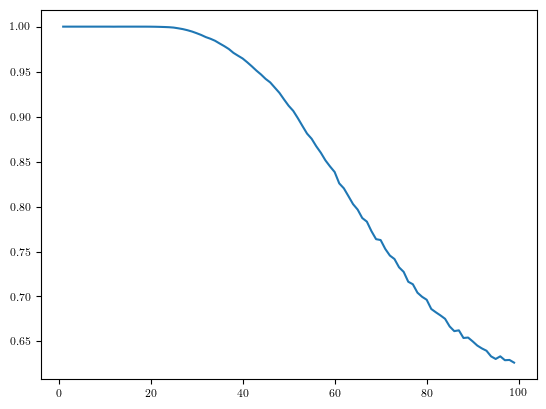

In [24]:
plt.plot(ns, aucs)
print(ns[aucs == np.min(aucs)], '\t', aucs[aucs == np.min(aucs)])